In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/DATA")
!ls

Mounted at /content/drive
Emotions.txt	   ner.csv			   special_tokens_map.json
glove.6B.200d.txt  ner_dataset.csv		   theta.txt
glove.6B.50d.txt   NHC_data_Biju.xlsx		   tokenizer_config.json
model_100.pth	   Quora_question_pairs_test.csv   vocab.txt
model.png	   Quora_question_pairs_train.csv


In [2]:
import numpy as np
import pandas as pd
import math
import torch
from torch.utils import data

# Load the dataset

In [3]:
df = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')

In [4]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [5]:
count_tags = df['Tag'].value_counts()

In [6]:
count_tags

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [7]:
count_tags['O'] + count_tags["B-gpe"]

903778

In [8]:
import string
df['Word'] = df['Word'].str.translate(str.maketrans('','',string.punctuation))
df['Word'] = df['Word'].str.lower()


# Embedding

In [9]:
## upload word emebedding file on google drive
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words, words_to_index, index_to_words, word_to_vec_map

In [10]:
words, word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [11]:
vocab_len = len(word_to_index) + 2            
emb_dim = word_to_vec_map["cucumber"].shape[0]  
emb_matrix = np.zeros((vocab_len, emb_dim))
for word, index in word_to_index.items():
    emb_matrix[index, :] = word_to_vec_map[word]
print(emb_matrix.shape)

(400002, 50)


# Extract mappings

In [12]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        n=2
        vocab = list(set(data['Word'].to_list()))
    else:
        n=0
        vocab = list(set(data['Tag'].to_list()))


    idx2tok = {idx:tok for  idx, tok in enumerate(vocab, n)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab, n)}
    return tok2idx, idx2tok

In [13]:
token2idx, idx2token = get_dict_map(df, 'token')
tag2idx, idx2tag = get_dict_map(df, 'tag')

In [14]:
token2idx['<PAD>'] = 1
idx2token[1] = '<PAD>'

In [15]:
token2idx['UNK'] = 0
idx2token[0] = '<UNK>'

In [16]:
df['Word_idx'] = df['Word'].map(word_to_index)
df['Tag_idx'] = df['Tag'].map(tag2idx)
df.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,thousands,NNS,O,358481.0,8
1,NaN,of,IN,O,268046.0,8
2,NaN,demonstrators,NNS,O,120649.0,8
3,NaN,have,VBP,O,174642.0,8
4,NaN,marched,VBN,O,234138.0,8


In [17]:
unique_tokens = len(word_to_index) # len(list(set(data['Word'].to_list())))
unique_tags = len(list(set(df['Tag'].to_list())))

In [18]:
df_fill = df.fillna(method='ffill', axis=0)

In [19]:
df_fill.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,thousands,NNS,O,358481.0,8
1,Sentence: 1,of,IN,O,268046.0,8
2,Sentence: 1,demonstrators,NNS,O,120649.0,8
3,Sentence: 1,have,VBP,O,174642.0,8
4,Sentence: 1,marched,VBN,O,234138.0,8


In [20]:
df_group = df_fill.groupby(['Sentence #'],as_index=False)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [21]:
df_group.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[358481.0, 268046.0, 120649.0, 174642.0, 23413...","[8, 8, 8, 8, 8, 8, 14, 8, 8, 8, 8, 8, 14, 8, 8..."
1,Sentence: 10,"[iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[192569.0, 268225.0, 319691.0, 357810.0, 14275...","[15, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
2,Sentence: 100,"[helicopter, gunships, saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[176329.0, 169259.0, 319134.0, 290058.0, 24443...","[8, 8, 3, 8, 8, 8, 8, 8, 14, 8, 8, 8, 8, 8, 5,..."
3,Sentence: 1000,"[they, left, after, a, tense, hourlong, stando...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[357810.0, 219577.0, 47798.0, 43010.0, 355882....","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]"
4,Sentence: 10000,"[un, relief, coordinator, jan, egeland, said, ...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[370622.0, 305053.0, 108674.0, 195458.0, 13404...","[14, 8, 8, 11, 16, 8, 3, 8, 14, 8, 15, 8, 15, ..."


# Data Loader 

In [22]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    #maxlen = 40
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= token2idx['<PAD>'])
    
    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    #n_tags = len(tag2idx)
    #pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.3, train_size=0.7, random_state=2020)
    

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags),
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(df_group, df)

train_tokens length: 33571 
test_tokens length: 14388 
train_tags: 33571 
test_tags: 14388


In [23]:
def data_iterator(tokens, tags, batch_size, shuffle=False):
    order = list(range(len(tokens)))
    for i in range((len(tokens)+1)//batch_size):
        batch_data = [tokens[idx] for idx in order[i*batch_size:(i+1)*batch_size]]
        batch_labels = [tags[idx] for idx in order[i*batch_size:(i+1)*batch_size]]
        
        batch_data, batch_labels = torch.LongTensor(batch_data), torch.LongTensor(batch_labels)
        batch_data = batch_data.transpose(0, 1).contiguous()
        batch_labels = batch_labels.transpose(0, 1).contiguous()
    
        batch_data, batch_labels = batch_data.cuda(), batch_labels.cuda()
        yield batch_data, batch_labels

In [24]:
train_data_iterator =  data_iterator(train_tokens, train_tags,4, shuffle=True)
train_batch, labels_batch = next(train_data_iterator)
print(train_batch.shape, labels_batch.shape)

torch.Size([104, 4]) torch.Size([104, 4])


# Transformer Model

In [25]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [26]:
emb_matrix = torch.FloatTensor(emb_matrix)
embedding = torch.nn.Embedding.from_pretrained(emb_matrix,freeze=True)

In [27]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_heads, hidden_dim, num_layers, num_labels, pad_idx, dropout=0.5, device="cuda"):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.encoder = embedding # nn.Embedding(vocab_size, embedding_size)
        self.pos_encoder = PositionalEncoding(embedding_size, dropout)
        encoder_layers = TransformerEncoderLayer(embedding_size, num_heads, hidden_dim, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc_out = nn.Linear(embedding_size, num_labels)
        self.dropout = nn.Dropout(dropout)
        self.pad_idx = pad_idx
        self.embedding_size = embedding_size
        self.device = device


    def make_src_mask(self, src):
        # use src_mask to ignore pad indices embeddings while computing self-attention output
        src_mask = src.transpose(0, 1) == self.pad_idx
        return src_mask.to(self.device)

    def forward(self, src):
        src_mask = self.make_src_mask(src)
        src = self.encoder(src) * math.sqrt(self.embedding_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask=src_mask)
        output = self.fc_out(output)
        return output

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(word_to_index) + 2
num_classes = unique_tags
embedding_size = 50
num_heads = 5
pad_idx = 1
num_layers = 6
dropout = 0.2
hidden_dim = 2048

In [30]:
model = TransformerModel(vocab_size, embedding_size, num_heads,hidden_dim, num_layers, num_classes, pad_idx, dropout, device).to(device)

In [31]:
!pip install torchsummaryX

In [32]:
from torchsummaryX import summary
summary(model, torch.zeros((20, 4)).long().cuda())

                                                  Kernel Shape   Output Shape  \
Layer                                                                           
0_encoder                                         [50, 400002]    [20, 4, 50]   
1_pos_encoder.Dropout_dropout                                -    [20, 4, 50]   
2_transformer_encoder.layers.0.Dropout_dropout1              -    [20, 4, 50]   
3_transformer_encoder.layers.0.LayerNorm_norm1            [50]    [20, 4, 50]   
4_transformer_encoder.layers.0.Linear_linear1       [50, 2048]  [20, 4, 2048]   
5_transformer_encoder.layers.0.Dropout_dropout               -  [20, 4, 2048]   
6_transformer_encoder.layers.0.Linear_linear2       [2048, 50]    [20, 4, 50]   
7_transformer_encoder.layers.0.Dropout_dropout2              -    [20, 4, 50]   
8_transformer_encoder.layers.0.LayerNorm_norm2            [50]    [20, 4, 50]   
9_transformer_encoder.layers.1.Dropout_dropout1              -    [20, 4, 50]   
10_transformer_encoder.layer

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder,"[50, 400002]","[20, 4, 50]",NaN,NaN
1_pos_encoder.Dropout_dropout,-,"[20, 4, 50]",NaN,NaN
2_transformer_encoder.layers.0.Dropout_dropout1,-,"[20, 4, 50]",NaN,NaN
3_transformer_encoder.layers.0.LayerNorm_norm1,[50],"[20, 4, 50]",100.0,50.0
4_transformer_encoder.layers.0.Linear_linear1,"[50, 2048]","[20, 4, 2048]",104448.0,102400.0
5_transformer_encoder.layers.0.Dropout_dropout,-,"[20, 4, 2048]",NaN,NaN
6_transformer_encoder.layers.0.Linear_linear2,"[2048, 50]","[20, 4, 50]",102450.0,102400.0
7_transformer_encoder.layers.0.Dropout_dropout2,-,"[20, 4, 50]",NaN,NaN
8_transformer_encoder.layers.0.LayerNorm_norm2,[50],"[20, 4, 50]",100.0,50.0


# Training and Validation

In [33]:
def accuracy(outputs, labels):
    labels = labels.ravel()
    mask = (labels >= 0)
    outputs = np.argmax(outputs, axis=1)
    return np.sum(outputs == labels)/float(np.sum(mask))
metrics = {
    'accuracy': accuracy,
}

In [34]:
from tqdm import trange
def train(model, optimizer, loss_fn, data_iterator, metrics, num_steps):
    model.train()
    summ = []
    t = trange(num_steps)
    for i in t:
        train_batch, labels_batch = next(data_iterator)
        output_batch = model(train_batch)
        output_batch = output_batch.view(output_batch.shape[0]*output_batch.shape[1], output_batch.shape[2])
        labels_batch = labels_batch.view(labels_batch.shape[0]*labels_batch.shape[1],)
        loss = loss_fn(output_batch, labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            output_batch = output_batch.data.cpu().numpy()
            labels_batch = labels_batch.data.cpu().numpy()
            summary_batch = {metric: metrics[metric](output_batch, labels_batch)
                             for metric in metrics}
            summary_batch['loss'] = loss.item()
            summ.append(summary_batch)

    metrics_mean = {metric: np.mean([x[metric]
                                     for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v)
                                for k, v in metrics_mean.items())
    print("- Train metrics: " + metrics_string)

In [35]:
def evaluate(model, loss_fn, data_iterator, metrics, num_steps):
    model.eval()
    summ = []
    for _ in range(num_steps):
        data_batch, labels_batch = next(data_iterator)
        output_batch = model(data_batch)
        output_batch = output_batch.view(output_batch.shape[0]*output_batch.shape[1], output_batch.shape[2])
        labels_batch = labels_batch.view(labels_batch.shape[0]*labels_batch.shape[1],)
        loss = loss_fn(output_batch, labels_batch)
        output_batch = output_batch.data.cpu().numpy()
        labels_batch = labels_batch.data.cpu().numpy()
        summary_batch = {metric: metrics[metric](output_batch, labels_batch)
                         for metric in metrics}
        summary_batch['loss'] = loss.item()
        summ.append(summary_batch)
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]} 
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    print("- Eval metrics : " + metrics_string)
    return metrics_mean

In [36]:
total_tags = 0
for tag in tag2idx.keys():
    total_tags += count_tags[tag]
class_weights = [0 for _ in range(unique_tags)]
for tag, idx in tag2idx.items():
    class_weights[idx] = 1/count_tags[tag]
class_weights = torch.FloatTensor(class_weights).cuda()
print(class_weights)

tensor([1.9608e-02, 4.9751e-03, 1.3488e-04, 4.9181e-05, 3.9526e-03, 4.9645e-05,
        5.9581e-05, 2.4876e-03, 1.1262e-06, 3.3670e-03, 1.5319e-04, 5.8858e-05,
        3.2468e-03, 5.0505e-03, 2.6565e-05, 6.3012e-05, 5.7968e-05],
       device='cuda:0')


In [37]:
batch_size = 128
num_epochs = 40

def train_and_evaluate(model, train_tokens, train_tags, val_tokens, val_tags, optimizer, metrics):
    loss_fn = nn.CrossEntropyLoss(class_weights, ignore_index=-1, reduction='mean')
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        num_steps = (len(train_tokens) + 1) // batch_size
        train_data_iterator = data_iterator(train_tokens, train_tags, batch_size, shuffle=True)
        train(model, optimizer, loss_fn, train_data_iterator, metrics, num_steps)
        num_steps = (len(val_tokens) + 1) // batch_size
        val_data_iterator = data_iterator(val_tokens, val_tags, batch_size, shuffle=False)
        val_metrics = evaluate(model, loss_fn, val_data_iterator, metrics, num_steps)

In [38]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

In [39]:
train_and_evaluate(model, train_tokens, train_tags, test_tokens, test_tags, optimizer, metrics)

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch 1/40


100%|██████████| 262/262 [00:18<00:00, 13.97it/s]


- Train metrics: accuracy: 0.594 ; loss: 2.266


  1%|          | 3/262 [00:00<00:14, 18.38it/s]

- Eval metrics : accuracy: 0.866 ; loss: 1.641
Epoch 2/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.869 ; loss: 1.583


  1%|          | 3/262 [00:00<00:14, 18.41it/s]

- Eval metrics : accuracy: 0.875 ; loss: 1.386
Epoch 3/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.870 ; loss: 1.460


  1%|          | 3/262 [00:00<00:13, 18.57it/s]

- Eval metrics : accuracy: 0.883 ; loss: 1.237
Epoch 4/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.875 ; loss: 1.303


  1%|          | 3/262 [00:00<00:13, 18.61it/s]

- Eval metrics : accuracy: 0.885 ; loss: 1.161
Epoch 5/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.873 ; loss: 1.218


  1%|          | 3/262 [00:00<00:14, 18.40it/s]

- Eval metrics : accuracy: 0.898 ; loss: 1.120
Epoch 6/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.886 ; loss: 1.219


  1%|          | 3/262 [00:00<00:14, 18.19it/s]

- Eval metrics : accuracy: 0.894 ; loss: 1.107
Epoch 7/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.889 ; loss: 1.208


  1%|          | 3/262 [00:00<00:14, 18.22it/s]

- Eval metrics : accuracy: 0.907 ; loss: 1.075
Epoch 8/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.891 ; loss: 1.172


  1%|          | 3/262 [00:00<00:14, 18.38it/s]

- Eval metrics : accuracy: 0.900 ; loss: 1.064
Epoch 9/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.886 ; loss: 1.218


  1%|          | 3/262 [00:00<00:13, 18.57it/s]

- Eval metrics : accuracy: 0.906 ; loss: 1.046
Epoch 10/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.887 ; loss: 1.175


  1%|          | 3/262 [00:00<00:14, 18.23it/s]

- Eval metrics : accuracy: 0.901 ; loss: 1.087
Epoch 11/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.890 ; loss: 1.110


  1%|          | 3/262 [00:00<00:13, 18.65it/s]

- Eval metrics : accuracy: 0.897 ; loss: 1.046
Epoch 12/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.890 ; loss: 1.063


  1%|          | 3/262 [00:00<00:14, 18.32it/s]

- Eval metrics : accuracy: 0.903 ; loss: 1.033
Epoch 13/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.890 ; loss: 1.115


  1%|          | 3/262 [00:00<00:13, 18.54it/s]

- Eval metrics : accuracy: 0.902 ; loss: 1.016
Epoch 14/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.892 ; loss: 1.040


  1%|          | 3/262 [00:00<00:14, 18.31it/s]

- Eval metrics : accuracy: 0.909 ; loss: 0.979
Epoch 15/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.900 ; loss: 0.990


  1%|          | 3/262 [00:00<00:13, 18.56it/s]

- Eval metrics : accuracy: 0.911 ; loss: 0.976
Epoch 16/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.894 ; loss: 1.011


  1%|          | 3/262 [00:00<00:13, 18.56it/s]

- Eval metrics : accuracy: 0.925 ; loss: 0.955
Epoch 17/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.902 ; loss: 1.072


  1%|          | 3/262 [00:00<00:14, 17.85it/s]

- Eval metrics : accuracy: 0.905 ; loss: 0.963
Epoch 18/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.898 ; loss: 1.029


  1%|          | 3/262 [00:00<00:13, 18.62it/s]

- Eval metrics : accuracy: 0.916 ; loss: 0.957
Epoch 19/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.904 ; loss: 0.924


  1%|          | 3/262 [00:00<00:14, 18.24it/s]

- Eval metrics : accuracy: 0.913 ; loss: 0.944
Epoch 20/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.903 ; loss: 1.038


  1%|          | 3/262 [00:00<00:14, 18.16it/s]

- Eval metrics : accuracy: 0.911 ; loss: 0.948
Epoch 21/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.904 ; loss: 0.970


  1%|          | 3/262 [00:00<00:13, 18.53it/s]

- Eval metrics : accuracy: 0.916 ; loss: 0.923
Epoch 22/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.905 ; loss: 1.034


  1%|          | 3/262 [00:00<00:13, 18.64it/s]

- Eval metrics : accuracy: 0.917 ; loss: 0.939
Epoch 23/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.905 ; loss: 0.920


  1%|          | 3/262 [00:00<00:14, 18.42it/s]

- Eval metrics : accuracy: 0.916 ; loss: 0.919
Epoch 24/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.906 ; loss: 0.985


  1%|          | 3/262 [00:00<00:13, 18.52it/s]

- Eval metrics : accuracy: 0.919 ; loss: 0.933
Epoch 25/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.905 ; loss: 0.855


  1%|          | 3/262 [00:00<00:13, 18.60it/s]

- Eval metrics : accuracy: 0.915 ; loss: 0.917
Epoch 26/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.908 ; loss: 0.885


  1%|          | 3/262 [00:00<00:13, 18.53it/s]

- Eval metrics : accuracy: 0.900 ; loss: 0.986
Epoch 27/40


100%|██████████| 262/262 [00:18<00:00, 13.99it/s]


- Train metrics: accuracy: 0.908 ; loss: 0.948


  1%|          | 3/262 [00:00<00:13, 18.58it/s]

- Eval metrics : accuracy: 0.919 ; loss: 0.937
Epoch 28/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.908 ; loss: 0.924


  1%|          | 3/262 [00:00<00:14, 18.32it/s]

- Eval metrics : accuracy: 0.919 ; loss: 0.909
Epoch 29/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.904 ; loss: 0.964


  1%|          | 3/262 [00:00<00:14, 18.22it/s]

- Eval metrics : accuracy: 0.919 ; loss: 0.904
Epoch 30/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.911 ; loss: 0.807


  1%|          | 3/262 [00:00<00:14, 18.29it/s]

- Eval metrics : accuracy: 0.922 ; loss: 0.904
Epoch 31/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.911 ; loss: 0.924


  1%|          | 3/262 [00:00<00:14, 18.41it/s]

- Eval metrics : accuracy: 0.919 ; loss: 0.899
Epoch 32/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.912 ; loss: 0.872


  1%|          | 3/262 [00:00<00:13, 18.54it/s]

- Eval metrics : accuracy: 0.913 ; loss: 0.910
Epoch 33/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.905 ; loss: 0.957


  1%|          | 3/262 [00:00<00:13, 18.55it/s]

- Eval metrics : accuracy: 0.916 ; loss: 0.903
Epoch 34/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.906 ; loss: 0.887


  1%|          | 3/262 [00:00<00:14, 18.36it/s]

- Eval metrics : accuracy: 0.917 ; loss: 0.890
Epoch 35/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.908 ; loss: 0.805


  1%|          | 3/262 [00:00<00:14, 18.41it/s]

- Eval metrics : accuracy: 0.916 ; loss: 0.888
Epoch 36/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.911 ; loss: 0.793


  1%|          | 3/262 [00:00<00:14, 18.27it/s]

- Eval metrics : accuracy: 0.915 ; loss: 0.906
Epoch 37/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.910 ; loss: 0.798


  1%|          | 3/262 [00:00<00:14, 18.35it/s]

- Eval metrics : accuracy: 0.920 ; loss: 0.893
Epoch 38/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.912 ; loss: 0.816


  1%|          | 3/262 [00:00<00:14, 18.14it/s]

- Eval metrics : accuracy: 0.923 ; loss: 0.888
Epoch 39/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.916 ; loss: 0.835


  1%|          | 3/262 [00:00<00:14, 18.26it/s]

- Eval metrics : accuracy: 0.914 ; loss: 0.895
Epoch 40/40


100%|██████████| 262/262 [00:18<00:00, 13.98it/s]


- Train metrics: accuracy: 0.910 ; loss: 0.829
- Eval metrics : accuracy: 0.919 ; loss: 0.896


In [40]:
torch.save(model.state_dict(), "model_100.pth")

In [41]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_conf_mat(model, tokens, tags):
    model.eval()
    summ = []
    conf_mat = np.zeros((unique_tags, unique_tags))
    print("unique_tags",unique_tags, conf_mat.shape)
    for idx in trange(len(tokens)):
        data = [tokens[idx]]
        labels = tags[idx]
        data = torch.LongTensor(data)
        data = data.transpose(0, 1).contiguous().cuda()
        outputs = model(data)
        outputs = outputs.view(outputs.shape[0]*outputs.shape[1], outputs.shape[2])
        outputs = outputs.data.cpu().numpy()
        outputs = np.argmax(outputs, axis=1)
        for i, j in  zip(labels, outputs):
            conf_mat[i][j]+=1
            
    df_cm = pd.DataFrame(conf_mat, index = list(tag2idx.keys()), columns = list(tag2idx.keys()))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    
    for i in range(unique_tags):
        print()
        print(idx2tag[i].upper())
        print("precision", conf_mat[i][i]/np.sum(conf_mat.T[i]))
        print("recall", conf_mat[i][i]/np.sum(conf_mat[i]))

  0%|          | 22/14388 [00:00<01:05, 219.79it/s]

unique_tags 17 (17, 17)


100%|██████████| 14388/14388 [01:01<00:00, 232.54it/s]



I-NAT
precision 0.026845637583892617
recall 0.75

B-NAT
precision 0.016827934371055953
recall 0.625

I-GEO
precision 0.13834811657643128
recall 0.533303730017762

B-TIM
precision 0.2778262328077826
recall 0.6833333333333333

I-EVE
precision 0.017891130567186907
recall 0.6438356164383562

B-ORG
precision 0.19544186046511627
recall 0.35075125208681135

I-ORG
precision 0.07835535810294575
recall 0.559168012924071

B-ART
precision 0.008173941474579042
recall 0.46296296296296297

O
precision 0.999139380234755
recall 0.9275665261391534

I-ART
precision 0.004862023653088042
recall 0.42528735632183906

I-TIM
precision 0.06217449416970088
recall 0.6903787103377687

B-PER
precision 0.38476350944758697
recall 0.6234399375975039

B-EVE
precision 0.045420699925539834
recall 0.6039603960396039

I-GPE
precision 0.052121212121212124
recall 0.5584415584415584

B-GEO
precision 0.5535725586988165
recall 0.7750310118731172

B-GPE
precision 0.6868591260451176
recall 0.9020095297286099

I-PER
precision 0.4

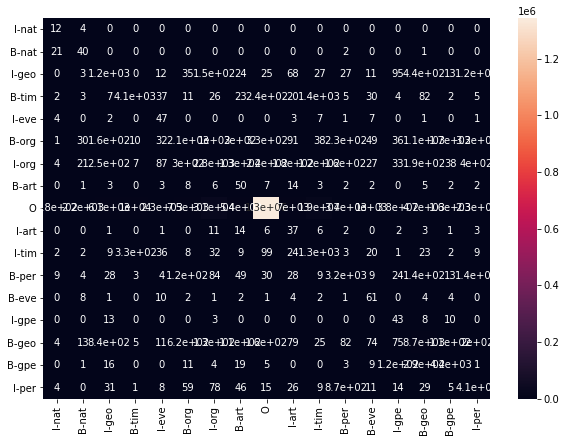

In [42]:
plot_conf_mat(model, test_tokens, test_tags)

In [43]:
model.load_state_dict(torch.load("./model_100.pth"))
model.eval()

TransformerModel(
  (encoder): Embedding(400002, 50)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=50, out_features=50, bias=True)
        )
        (li

In [44]:
def predict(model, sentence):
    model.eval()
    words = sentence.translate(str.maketrans('','',string.punctuation)).split()
    data = [[word_to_index[word.lower()] for word in words]]
    data = torch.LongTensor(data)
    data = data.transpose(0, 1).contiguous().cuda()
    outputs = model(data)
    outputs = outputs.view(outputs.shape[0]*outputs.shape[1], outputs.shape[2])
    outputs = outputs.data.cpu().numpy()
    outputs = np.argmax(outputs, axis=1)
    ner = ""
    for i, j in enumerate(outputs):
        ner =  ner + " " + words[i]+"("+idx2tag[j].upper()+")"
    print(ner.strip())

In [45]:
input_sentence = "Carrie Mathison, a CIA operations officer, conducts an unauthorized operation in Iraq and is reassigned to the CIA's Counterterrorism Center in Langley, Virginia. Nicholas Brody, a U.S. Marine Sergeant who had been reported as missing in action since 2003, is rescued from a compound belonging to terrorist Abu Nazir. Brody is heralded as a war hero, but Carrie comes to suspect that he is planning a terrorist attack against the United States."
predict(model, input_sentence)

Carrie(B-PER) Mathison(I-PER) a(O) CIA(B-ORG) operations(I-ORG) officer(I-ORG) conducts(I-ORG) an(O) unauthorized(B-ART) operation(B-EVE) in(O) Iraq(B-GEO) and(I-ORG) is(O) reassigned(B-ORG) to(O) the(O) CIAs(B-ART) Counterterrorism(I-ORG) Center(I-ART) in(O) Langley(I-ART) Virginia(I-GEO) Nicholas(B-PER) Brody(B-PER) a(O) US(B-GEO) Marine(I-ORG) Sergeant(I-ORG) who(O) had(O) been(O) reported(O) as(O) missing(O) in(O) action(O) since(B-TIM) 2003(B-TIM) is(O) rescued(O) from(O) a(O) compound(B-ART) belonging(I-ORG) to(O) terrorist(I-ORG) Abu(B-PER) Nazir(I-PER) Brody(B-PER) is(O) heralded(O) as(O) a(O) war(I-EVE) hero(O) but(O) Carrie(B-PER) comes(O) to(O) suspect(O) that(O) he(O) is(O) planning(I-ORG) a(O) terrorist(I-ORG) attack(O) against(O) the(O) United(B-GEO) States(I-GEO)
